# Preprocessing

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl ; mpl.rcParams['axes.unicode_minus'] = False
import matplotlib.pyplot as plt ; plt.rcParams['font.family'] = 'AppleGothic'
import seaborn as sns

---

In [2]:
# Train Data 불러오기 및 오류 데이터 제거
train = pd.read_csv('train.csv')
train_error = ['C2085', 'C1397', 'C2431', 'C1649', 'C1036', 'C1095', 'C2051', 'C1218', 'C1894', 'C2483', 'C1502', 'C1988']
train = train[~train['단지코드'].isin(train_error)].reset_index(drop=True)
print(train.shape)

(2869, 15)


In [3]:
# Test Data 불러오기 및 오류 데이터 제거
test = pd.read_csv('test.csv')
test_error = ['C2675', 'C2335', 'C1327']
test = test[~test['단지코드'].isin(test_error)].reset_index(drop=True)
print(test.shape)

(1008, 14)


---

In [4]:
print(train.loc[train['임대건물구분'] == '상가', '전용면적별세대수'].unique())

[1]


$\Rightarrow$ 임대건물구분이 '상가'인 경우는 무조건 한 세대

In [5]:
# Train Data의 '임대건물구분 == 상가' 데이터 제거, '임대건물구분' 변수 제거
train = train[train['임대건물구분'] != '상가'].reset_index(drop=True)
train.drop(['임대건물구분'], axis=1, inplace=True)
print(train.shape)

(2307, 14)


In [6]:
# Test Data의 '임대건물구분 == 상가' 데이터 제거, '임대건물구분' 변수 제거
test = test[test['임대건물구분'] != '상가'].reset_index(drop=True)
test.drop(['임대건물구분'], axis=1, inplace=True)
print(test.shape)

(831, 13)


---

In [7]:
# Train Data의 '전용면적별세대수합' 변수 생성
noh_by_area = train.groupby('단지코드', as_index=False).agg({'전용면적별세대수':'sum'}).rename(columns={'전용면적별세대수':'전용면적별세대수합'})
train = pd.merge(left=train, right=noh_by_area, how='left', on='단지코드')
print(train.shape)

(2307, 15)


In [8]:
# Test Data의 '전용면적별세대수합' 변수 생성
noh_by_area = test.groupby('단지코드', as_index=False).agg({'전용면적별세대수':'sum'}).rename(columns={'전용면적별세대수':'전용면적별세대수합'})
test = pd.merge(left=test, right=noh_by_area, how='left', on='단지코드')
print(test.shape)

(831, 14)


---

In [9]:
print(set(train['지역'].unique()) - set(test['지역'].unique()))
print(set(train['자격유형'].unique()) - set(test['자격유형'].unique()))
print(set(train['공급유형'].unique()) - set(test['공급유형'].unique()))

{'서울특별시'}
{'O', 'B', 'F'}
{'공공분양', '공공임대(5년)', '장기전세'}


In [10]:
# Test Data에 없는 카테고리 Train Data에서 제거
train = train[train['지역'] != '서울특별시'].reset_index(drop=True)
train = train[~train['자격유형'].isin(['F', 'O', 'B'])].reset_index(drop=True)
train = train[~train['공급유형'].isin(['공공임대(5년)', '공공분양', '장기전세'])].reset_index(drop=True)
print(train.shape)

(2222, 15)


---

In [11]:
# Train Data의 '임대보증금', '임대료'의 '-'를 0으로 변환
train['임대보증금'] = train['임대보증금'].replace('-', 0).astype('float64')
train['임대료'] = train['임대료'].replace('-', 0).astype('float64')

In [12]:
# Test Data의 '임대보증금', '임대료'의 '-'를 0으로 변환
test['임대보증금'] = test['임대보증금'].replace('-', 0).astype('float64')
test['임대료'] = test['임대료'].replace('-', 0).astype('float64')

---

In [13]:
# Train Data의 '도보 10분거리 내 지하철역 수(환승노선 수 반영)' NA 0으로 대체
train['도보 10분거리 내 지하철역 수(환승노선 수 반영)'] = train['도보 10분거리 내 지하철역 수(환승노선 수 반영)'].fillna(0)

In [14]:
# Test Data의 '도보 10분거리 내 지하철역 수(환승노선 수 반영)' NA 0으로 대체
test['도보 10분거리 내 지하철역 수(환승노선 수 반영)'] = test['도보 10분거리 내 지하철역 수(환승노선 수 반영)'].fillna(0)

---

In [15]:
# Test Data의 '단지코드' NA 특정값으로 대체
test.loc[test['단지코드'] == 'C2411', '자격유형'] = 'A'
test.loc[test['단지코드'] == 'C2253', '자격유형'] = 'D'

---

In [16]:
# Test Data의 '임대보증금', '임대료' NA 특정값으로 대체
test.loc[test['임대보증금'].isnull(), '임대보증금'] = [5787000.0, 5787000.0, 11574000.0]
test.loc[test['임대료'].isnull(), '임대료'] = [79980.0, 79980.0, 159960.0]

---

In [17]:
# Train Data의 '자격유형' 변수 재생성 (Major Voting)
qual_type = train.groupby(['단지코드', '자격유형'], as_index=False).agg({'전용면적별세대수':'sum'}).sort_values('전용면적별세대수', ascending=False).drop_duplicates('단지코드').reset_index(drop=True).drop(['전용면적별세대수'], axis=1)
train = pd.merge(train, qual_type, how='left', on='단지코드').drop('자격유형_x', axis=1).rename(columns={'자격유형_y':'자격유형'})

In [18]:
# Train Data의 '공급유형' 변수 재생성 (Major Voting)
supply_type = train.groupby(['단지코드', '공급유형'], as_index=False).agg({'전용면적별세대수':'sum'}).sort_values('전용면적별세대수', ascending=False).drop_duplicates('단지코드').reset_index(drop=True).drop(['전용면적별세대수'], axis=1)
train = pd.merge(train, supply_type, how='left', on='단지코드').drop('공급유형_x', axis=1).rename(columns={'공급유형_y':'공급유형'})

---

In [19]:
# Test Data의 '자격유형' 변수 재생성 (Major Voting)
qual_type = test.groupby(['단지코드', '자격유형'], as_index=False).agg({'전용면적별세대수':'sum'}).sort_values('전용면적별세대수', ascending=False).drop_duplicates('단지코드').reset_index(drop=True).drop(['전용면적별세대수'], axis=1)
test = pd.merge(test, qual_type, how='left', on='단지코드').drop('자격유형_x', axis=1).rename(columns={'자격유형_y':'자격유형'})

In [20]:
# Test Data의 '공급유형' 변수 재생성 (Major Voting)
supply_type = test.groupby(['단지코드', '공급유형'], as_index=False).agg({'전용면적별세대수':'sum'}).sort_values('전용면적별세대수', ascending=False).drop_duplicates('단지코드').reset_index(drop=True).drop(['전용면적별세대수'], axis=1)
test = pd.merge(test, supply_type, how='left', on='단지코드').drop('공급유형_x', axis=1).rename(columns={'공급유형_y':'공급유형'})

---

In [21]:
# Train Data의 '실세대수'='총세대수'-'공가수' 변수 생성, '총세대수', '공가수' 변수 제거
train['실세대수'] = train['총세대수'] - train['공가수']
train.drop(['총세대수', '공가수'], axis=1, inplace=True)
print(train.shape)

(2222, 14)


In [22]:
# Test Data의 '실세대수'='총세대수'-'공가수' 변수 생성, '총세대수', '공가수' 변수 제거
test['실세대수'] = test['총세대수'] - test['공가수']
test.drop(['총세대수', '공가수'], axis=1, inplace=True)
print(test.shape)

(831, 13)


---

In [23]:
# Train Data의 '임대료' 변수 재생성 (전용면적별세대수 가중 평균)
train['임대료'] = round(train['임대료'] * train['전용면적별세대수'] / train['전용면적별세대수합'])
rental_fee = train.groupby('단지코드', as_index=False).agg({'임대료':'sum'})
train = pd.merge(train, rental_fee, how='left', on='단지코드').drop(['임대료_x'], axis=1).rename(columns={'임대료_y':'임대료'})

In [24]:
# Test Data의 '임대료' 변수 재생성 (전용면적별세대수 가중 평균)
test['임대료'] = round(test['임대료'] * test['전용면적별세대수'] / test['전용면적별세대수합'])
rental_fee = test.groupby('단지코드', as_index=False).agg({'임대료':'sum'})
test = pd.merge(test, rental_fee, how='left', on='단지코드').drop(['임대료_x'], axis=1).rename(columns={'임대료_y':'임대료'})

---

In [25]:
train.head()

,단지코드,지역,전용면적,전용면적별세대수,임대보증금,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,등록차량수,전용면적별세대수합,자격유형,공급유형,실세대수,임대료
0,C2515,경상남도,33.48,276,9216000.0,0.0,3.0,624.0,205.0,545,A,국민임대,528.0,119432.0
1,C2515,경상남도,39.60,60,12672000.0,0.0,3.0,624.0,205.0,545,A,국민임대,528.0,119432.0
2,C2515,경상남도,39.60,20,12672000.0,0.0,3.0,624.0,205.0,545,A,국민임대,528.0,119432.0
3,C2515,경상남도,46.90,38,18433000.0,0.0,3.0,624.0,205.0,545,A,국민임대,528.0,119432.0
4,C2515,경상남도,46.90,19,18433000.0,0.0,3.0,624.0,205.0,545,A,국민임대,528.0,119432.0


In [26]:
train.isnull().sum()

단지코드                            0
지역                              0
전용면적                            0
전용면적별세대수                        0
임대보증금                           0
도보 10분거리 내 지하철역 수(환승노선 수 반영)    0
도보 10분거리 내 버스정류장 수              0
단지내주차면수                         0
등록차량수                           0
전용면적별세대수합                       0
자격유형                            0
공급유형                            0
실세대수                            0
임대료                             0
dtype: int64

In [27]:
test.head()

,단지코드,지역,전용면적,전용면적별세대수,임대보증금,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,전용면적별세대수합,자격유형,공급유형,실세대수,임대료
0,C1072,경기도,39.79,116,22830000.0,0.0,2.0,683.0,754,H,국민임대,740.0,264048.0
1,C1072,경기도,46.81,30,36048000.0,0.0,2.0,683.0,754,H,국민임대,740.0,264048.0
2,C1072,경기도,46.90,112,36048000.0,0.0,2.0,683.0,754,H,국민임대,740.0,264048.0
3,C1072,경기도,46.90,120,36048000.0,0.0,2.0,683.0,754,H,국민임대,740.0,264048.0
4,C1072,경기도,51.46,60,43497000.0,0.0,2.0,683.0,754,H,국민임대,740.0,264048.0


In [28]:
test.isnull().sum()

단지코드                            0
지역                              0
전용면적                            0
전용면적별세대수                        0
임대보증금                           0
도보 10분거리 내 지하철역 수(환승노선 수 반영)    0
도보 10분거리 내 버스정류장 수              0
단지내주차면수                         0
전용면적별세대수합                       0
자격유형                            0
공급유형                            0
실세대수                            0
임대료                             0
dtype: int64

In [29]:
print(train.shape, test.shape)

(2222, 14) (831, 13)


---

# Modeling

In [30]:
# Train Data의 '전용면적' 변수 재생성 (전용면적별세대수 가중 평균)
train['전용면적'] = round(train['전용면적'] * train['전용면적별세대수'] / train['전용면적별세대수합'])
rental_fee = train.groupby('단지코드', as_index=False).agg({'전용면적':'sum'})
train = pd.merge(train, rental_fee, how='left', on='단지코드').drop(['전용면적_x'], axis=1).rename(columns={'전용면적_y':'전용면적'})

In [31]:
tmp = train.drop(['전용면적별세대수', '임대보증금'], axis=1).drop_duplicates().reset_index(drop=True)

In [32]:
tmp['유형'] = tmp['공급유형'] + tmp['자격유형']
tmp.drop(['공급유형', '자격유형'], axis=1, inplace=True)

In [33]:
tmp = pd.get_dummies(tmp, columns=['지역', '유형'], drop_first=True)

In [34]:
X_train = tmp.drop(['단지코드', '등록차량수', '전용면적별세대수합'], axis=1)
y_train = tmp['등록차량수']

In [35]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

In [36]:
rf = RandomForestRegressor(n_jobs=-1, random_state=0)

In [37]:
score = cross_val_score(rf, X_train, y_train, cv=10, scoring='neg_mean_absolute_error')

In [38]:
print(f'평균: {-score.mean()} | 표준편차: {score.std()}')

평균: 136.67425548780486 | 표준편차: 33.18385125878566


In [39]:
rf.fit(X_train, y_train)

RandomForestRegressor(n_jobs=-1, random_state=0)

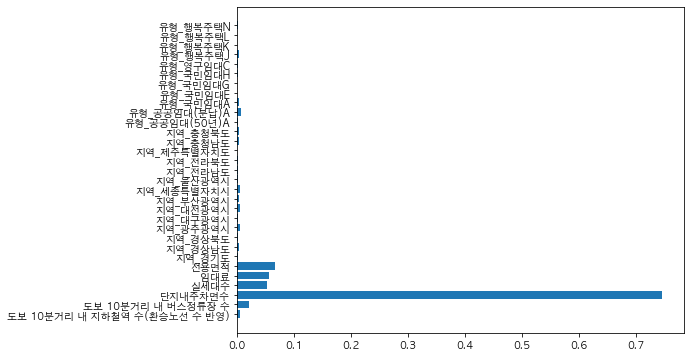

In [40]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.barh(X_train.columns, rf.feature_importances_)
plt.show()

---

# Test Data에 적용

In [41]:
# Test Data의 '전용면적' 변수 재생성 (전용면적별세대수 가중 평균)
test['전용면적'] = round(test['전용면적'] * test['전용면적별세대수'] / test['전용면적별세대수합'])
rental_fee = test.groupby('단지코드', as_index=False).agg({'전용면적':'sum'})
test = pd.merge(test, rental_fee, how='left', on='단지코드').drop(['전용면적_x'], axis=1).rename(columns={'전용면적_y':'전용면적'})

In [42]:
tmp_test = test.drop(['전용면적', '전용면적별세대수', '임대보증금'], axis=1).drop_duplicates().reset_index(drop=True)

In [43]:
tmp_test['유형'] = tmp_test['공급유형'] + tmp_test['자격유형']
tmp_test.drop(['공급유형', '자격유형'], axis=1, inplace=True)

In [44]:
X_test = tmp_test.drop(['단지코드', '전용면적별세대수합'], axis=1)

In [45]:
X_test = pd.get_dummies(X_test, columns=['지역', '유형'], drop_first=True)

In [46]:
tmp_test['등록차량수'] = rf.predict(X_test)

In [47]:
submission = tmp_test[['단지코드', '등록차량수']].rename(columns={'단지코드':'code', '등록차량수':'num'})

In [48]:
error = pd.DataFrame(np.array([['C2675', 0], ['C2335', 0], ['C1327', 0]]), columns=['code', 'num'])

In [49]:
submission = pd.concat([submission, error]).reset_index(drop=True)

In [50]:
# submission.to_csv('submission.csv', index=False)